In [64]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# for dimensionality reduction
from sklearn.decomposition import PCA

In [2]:
features = pd.read_csv('features_filtered.csv', encoding='latin')
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file
0,564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download
1,545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download
2,540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download
3,540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download
4,539275,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,Upper St. Clair Township (near Upper Saint Cl...,"call, song",no score,1:12,yes,//www.xeno-canto.org/539275/download


In [55]:
# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en']]
# Now we need to change our labels into integers as torch does not support string format for labels.
labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
dataset['label'] = dataset.apply(lambda row: labels[row.en], axis=1)
dataset.drop('en', axis=1, inplace=True)

In [56]:
def load_images(dataset, gray=True):
    img_df = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        image_path = 'images/mel_spectrograms_8sec/' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path)
#         # normalizing the pixel values
#         img /= 255.0
#         # converting the type of pixel to float 32
#         img = img.astype('float32')
        # appending the image into the list
        img_df.append(img.flatten())
    
    # converting the list to numpy array
    return np.array(img_df)


def visualizing_images(dataset):
    # Only works for 2D arrays
    i = 0
    plt.figure(figsize=(10,10))
    plt.subplot(221), plt.imshow(dataset[i], cmap='gray')
    plt.subplot(222), plt.imshow(dataset[i+25], cmap='gray')
    plt.subplot(223), plt.imshow(dataset[i+50], cmap='gray')
    plt.subplot(224), plt.imshow(dataset[i+75], cmap='gray')

In [57]:
X, y = load_images(dataset, gray=True), dataset['label'].values
X.shape, y.shape

100%|████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:01<00:00, 1296.19it/s]


((2516, 132480), (2516,))

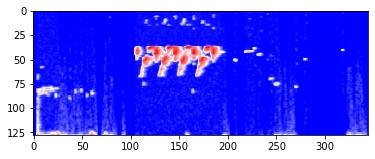

In [59]:
img = X[0].reshape(128, 345, 3)
plt.imshow(img, cmap='bwr')

# PCA - Dimensionality Reduction

In [69]:
def pca_reduction(parameter):
    '''Parameter should be percentage variance retained (e.g. 0.95) or number of components (e.g. 2)''' 
    pca_model = PCA(parameter)
    X_proj = pca_model.fit_transform(X)
    return pca_model, X_proj

def inv_transform(pca_model, reduced_X):
    '''Reconstructs the images using the reduced dataset using inverse transform to convert images back to their
    original dimension. Note that we are not reverting back to the original data, we're going back to the actual dimension
    of the original images so that we can visualize them. 
    ''' 
    X_inv_proj = pca_model.inverse_transform(reduced_X) 
    #reshaping as 2516 images of 128*1035 dimension 
    X_proj_img = np.reshape(X_inv_proj,(2516 , 128, 1035))
    return X_proj_img

def images_plot(images, n_dim, cmap):
    '''Dimensions are of shape (128*345*3) or (128*1035)'''
    if n_dim == 3:
        fig, axes = plt.subplots(5, 4, figsize=(15, 8),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].reshape(128, 345, 3), cmap=cmap)
    elif n_dim == 2:
        fig, axes = plt.subplots(5, 2, figsize=(20, 8),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].reshape(128, 1035), cmap=cmap)
    else:
        print('not enough or too many dimensions')

In [113]:
pca_model, X_proj = pca_reduction(0.98)
X_proj.shape

(2516, 1873)

In [114]:
X_proj_img = inv_transform(pca_model, X_proj)
X_proj_img.shape

(2516, 128, 1035)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

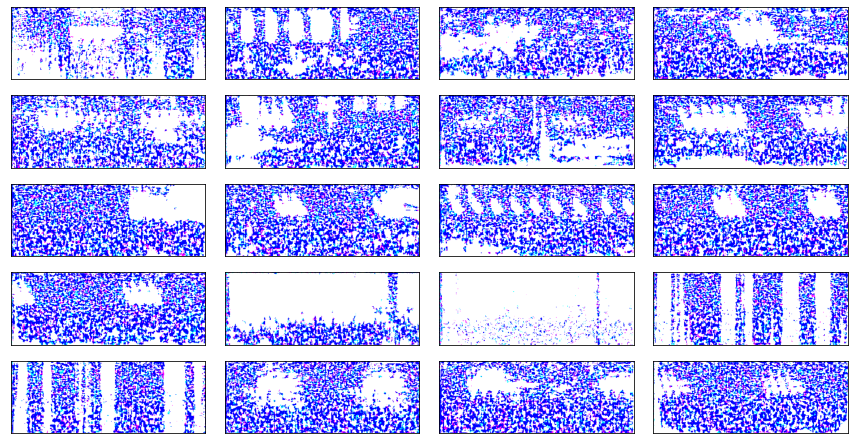

In [115]:
# Showing the pca-reduced images
images_plot(X_proj_img, 3, 'bwr')

# Random Forest 

In [116]:
# # Taking 20% of the dataset off for testing
X_train, X_test, y_train, y_test = train_test_split(pca_model.inverse_transform(X_proj), y, test_size=0.20, random_state=42)

print(X_train.shape)
print('')
print(X_test.shape)

(2012, 132480)

(504, 132480)


In [117]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0 87]
 [ 1 81]
 [ 2 88]
 [ 3 71]
 [ 4 81]
 [ 5 96]]


In [72]:
# X_train, y_train = load_images(train, dimensions='1D', gray=True), train['label'].values

In [73]:
# X_test, y_test = load_images(test, dimensions='1D', gray=True), test['label'].values

In [118]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=6)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [119]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.49007936507936506


In [120]:
from sklearn.metrics import f1_score
print("F1 score: ", f1_score(y_test, y_pred, average='micro'))
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.49007936507936506
F1 score:  0.4886213871902206


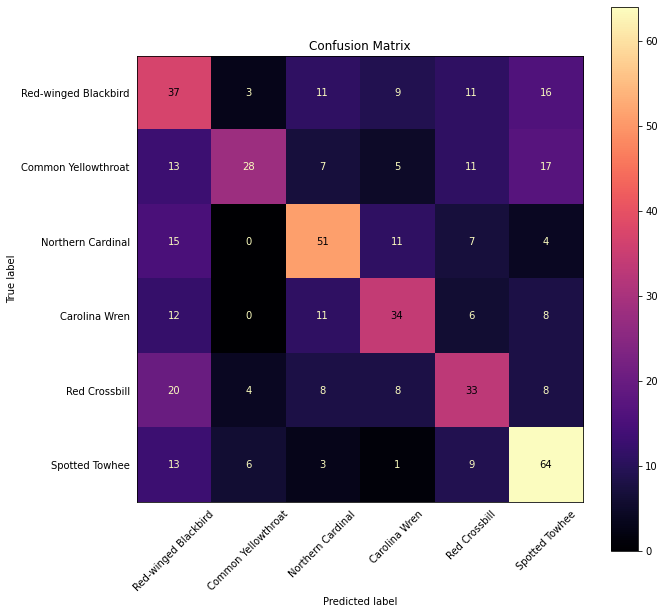

In [121]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_species)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

# To do
1. get the s-k-means to work
2. add dummy classifier to supervised for comparison
3. create validation dataset on (all?) models
4. get the CNN to run with the new images - try it with the reduced images just for fun
5. compare Random Forest's accuracy with accuracy on original mel-spectrograms (to see how much denoising helps - this one was on my to-do but not done yet)